In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [2]:
trainLabels = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
trainLabels.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
import numpy as np
import os
import time
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
#freeze_layers(base_model)
base_model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [5]:
for layer in base_model.layers[:-3]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)
base_model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8ef06a2b90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ea186fd90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ea1024810> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8ea037c510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ea0387c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ea0387e50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8ea0399a90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ea038a610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ea039cf90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ea03a7f50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8ea03a7210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

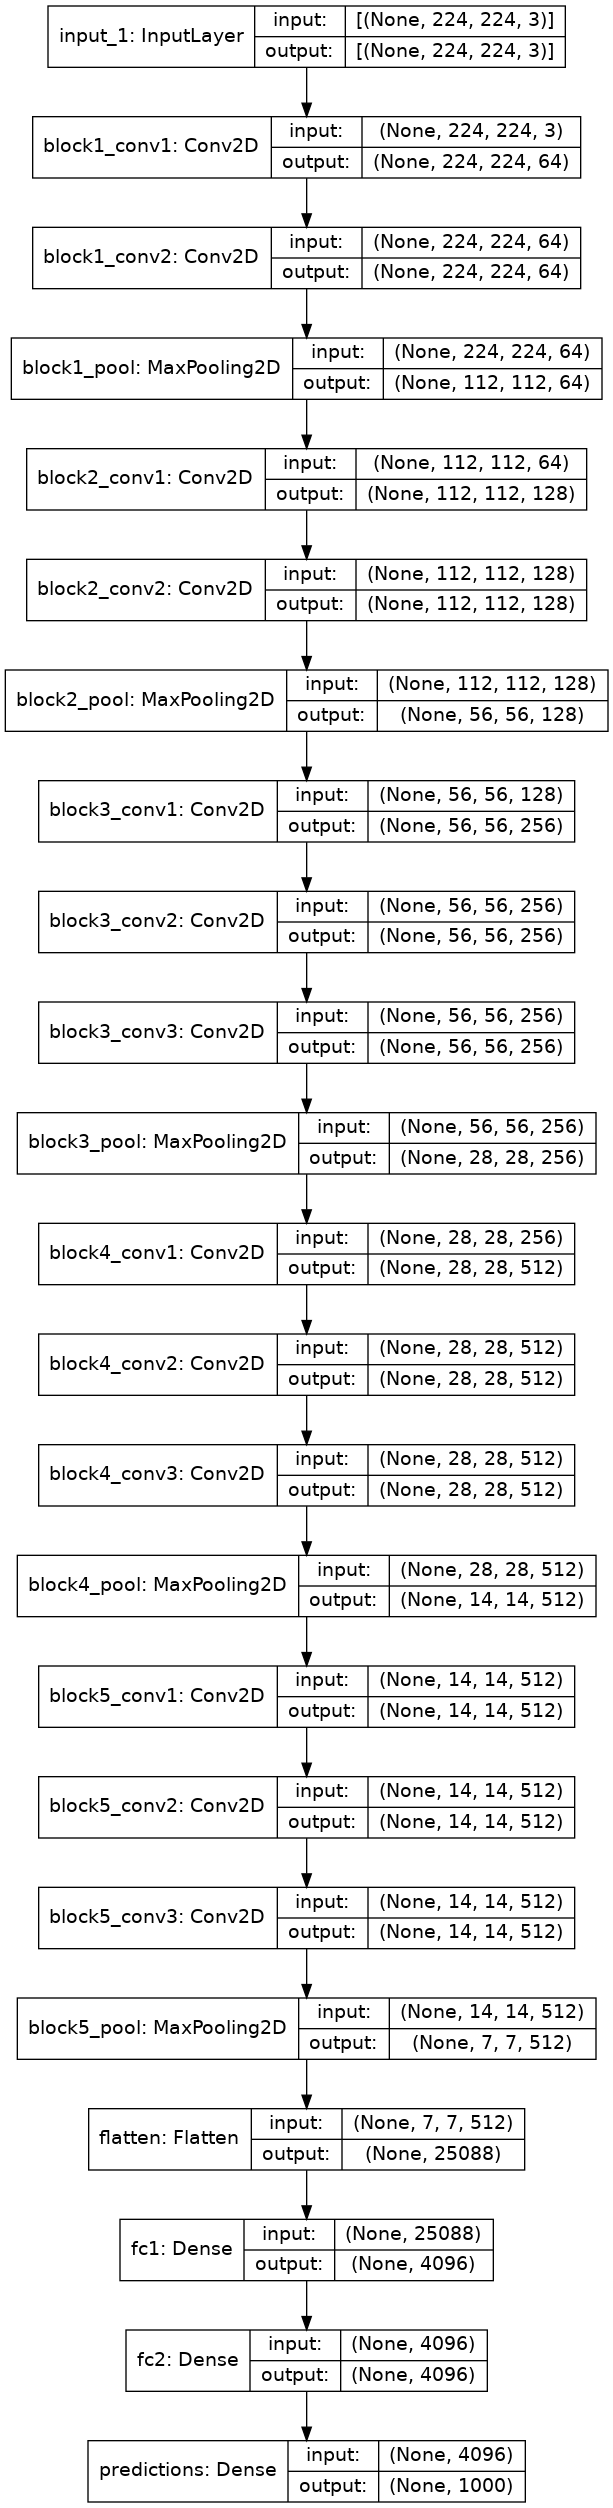

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(base_model, to_file='base_model_plot.png', show_shapes=True, show_layer_names=True)

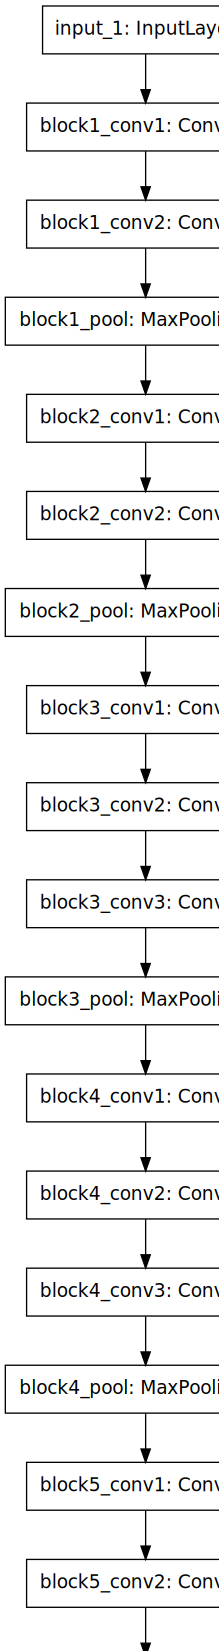

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_model).create(prog='dot', format='svg'))

In [8]:
#batch_size to train
batch_size = 32
# number of output classes
nb_classes = 5
# number of epochs to train
nb_epoch = 10

In [9]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(base_model)
 
# Add new layers
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(layers.Dense(nb_classes, activation='softmax', name ='output'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
dense (Dense)                (None, 4096)              4100096   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               2048500   
_________________________________________________________________
output (Dense)               (None, 5)                 2

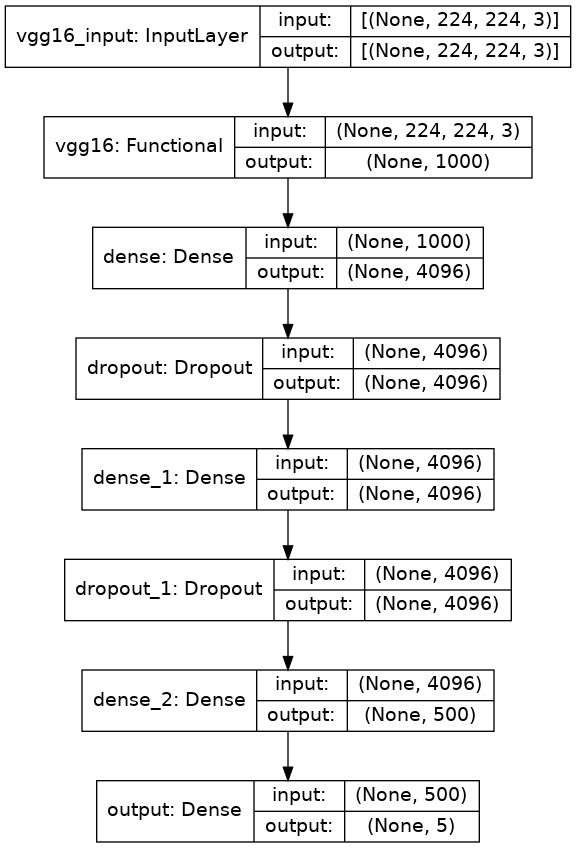

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='finetune_model_plot.png', show_shapes=True, show_layer_names=True)

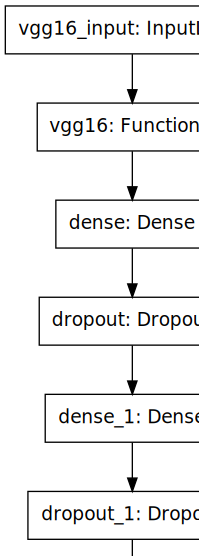

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
import pandas as pd
trainLabels = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
trainLabels.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='diagnosis', ylabel='count'>

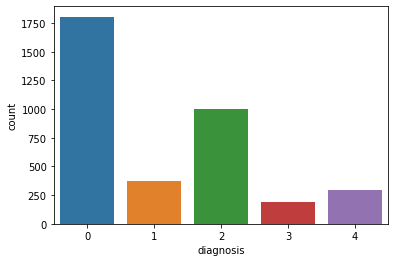

In [13]:
import seaborn as sns
sns.countplot("diagnosis",data= trainLabels)

In [14]:
import os

listing = os.listdir("../input/aptos2019-blindness-detection/train_images/") 
#listing.remove("train.csv")
#listing.remove("test.csv")
np.size(listing)

3662

In [16]:
from PIL import Image

# input image dimensions
img_rows, img_cols = 224, 224

immatrix = []
imlabel = []

for file in listing:
    base = os.path.basename("../input/aptos2019-blindness-detection/train_images/" + file)
    fileName = os.path.splitext(base)[0]
    imlabel.append(trainLabels.loc[(trainLabels.id_code)==fileName, 'diagnosis'].values[0])
    im = Image.open("../input/aptos2019-blindness-detection/train_images/" + file)   
    img = im.resize((img_rows,img_cols))
    rgb = img.convert('RGB')
    immatrix.append(np.array(rgb).flatten())

In [17]:
from sklearn.utils import shuffle

#converting images & labels to numpy arrays
immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)


data,Label = shuffle(immatrix,imlabel, random_state=2)
train_data = [data,Label]
type(train_data)

list

severity 0
severity 2
severity 0
severity 0
severity 4
severity 0
severity 0
severity 0
severity 2
severity 0


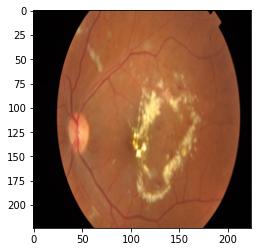

In [18]:
import matplotlib.pyplot as plt
import matplotlib
for i in range (10):
    img=immatrix[i].reshape(img_rows,img_cols,3)
    print('severity',imlabel[i])
    if(imlabel[i]>0):
        plt.imshow(img)

In [38]:
(X, y) = (train_data[0],train_data[1])
from sklearn.model_selection import train_test_split

# STEP 1: split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 3)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 3)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2929, 224, 224, 3)
(2929,)
(733, 224, 224, 3)
(733,)


In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   # all pixel values will be between 0 an 1
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)



In [41]:
# X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 3)
# X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (2929, 224, 224, 3)
2929 train samples
733 test samples


In [42]:
from keras.utils import np_utils

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [43]:
from keras.preprocessing.image import ImageDataGenerator

# create generators  - training data will be augmented images
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

batchsize=12
train_generator=traindatagenerator.flow(X_train, Y_train, batch_size=batchsize) 
validation_generator=validationdatagenerator.flow(X_test, Y_test,batch_size=batchsize)

In [44]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
from keras import backend as K
from keras.optimizers import RMSprop
K.set_value(model.optimizer.learning_rate, 0.00001)
train_datagen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
#train_batches = model.get_batches('train', gen=train_datagen, class_mode='categorical', batch_size=BATCH_SIZE)
#valid_batches = model.get_batches('valid', gen=test_datagen, class_mode='categorical', batch_size=BATCH_SIZE)
model.compile(optimizer=RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, epochs=15,
                            steps_per_epoch=2000 // batchsize,
                            validation_data=validation_generator,
                            validation_steps=800 // batchsize)

#history= model.fit_generator(train_generator, steps_per_epoch=int(len(X_train)/batchsize), 
                    #epochs=10, validation_data=validation_generator, 
                    #validation_steps=int(len(X_test)/batchsize))

Epoch 1/15
166/166 [==============================] - 299s 2s/step - loss: 3.1689 - accuracy: 0.4792 - val_loss: 2.9574 - val_accuracy: 0.4939
Epoch 2/15
166/166 [==============================] - 299s 2s/step - loss: 2.9166 - accuracy: 0.4909 - val_loss: 2.7241 - val_accuracy: 0.4939
Epoch 3/15
166/166 [==============================] - 298s 2s/step - loss: 2.6575 - accuracy: 0.5012 - val_loss: 2.5284 - val_accuracy: 0.4939
Epoch 4/15
166/166 [==============================] - 298s 2s/step - loss: 2.4559 - accuracy: 0.5183 - val_loss: 2.3656 - val_accuracy: 0.4939
Epoch 5/15
166/166 [==============================] - 299s 2s/step - loss: 2.3279 - accuracy: 0.5002 - val_loss: 2.2276 - val_accuracy: 0.4939
Epoch 6/15
166/166 [==============================] - 299s 2s/step - loss: 2.1764 - accuracy: 0.5142 - val_loss: 2.1169 - val_accuracy: 0.4939
Epoch 7/15
166/166 [==============================] - 298s 2s/step - loss: 2.1253 - accuracy: 0.4805 - val_loss: 2.0248 - val_accuracy: 0.4939

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)